In [1]:
## Enviroment Setup
import os, sys
DIR = os.getcwd()
WORKING_DIR = '/home/peizhi/Documents/flame-head-tracker'
os.chdir(WORKING_DIR) # change the working directory to the project's absolute path
print("Current Working Directory: ", os.getcwd())

## Computing Device
device = 'cuda:0'
import torch
torch.cuda.set_device(device) # this will solve the problem that OpenGL not on the same device with torch tensors

sys.path.append(WORKING_DIR)
sys.path.append('./utils/flame_lib/')
sys.path.append('./utils/flame_fitting/')
sys.path.append('./utils/face_parsing/')
sys.path.append('./utils/decalib/')
sys.path.append('./utils/mesh_renderer')
sys.path.append('./utils/scene')

import matplotlib.pyplot as plt
import numpy as np
import cv2

from tracker_base import Tracker

from utils.graphics_utils import create_diff_world_to_view_matrix, verts_clip_to_ndc
from utils.scene.cameras import PerspectiveCamera
from utils.mesh_renderer import NVDiffRenderer


Current Working Directory:  /home/peizhi/Documents/flame-head-tracker
Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:

###########################
## Setup Flame Tracker    #     
###########################

tracker_cfg = {
    'mediapipe_face_landmarker_v2_path': './models/face_landmarker_v2_with_blendshapes.task',
    'flame_model_path': './models/FLAME2020/generic_model.pkl',
    'flame_lmk_embedding_path': './models/landmark_embedding.npy',
    'tex_space_path': './models/FLAME_texture.npz',
    'face_parsing_model_path': './utils/face_parsing/79999_iter.pth',
    'uv_coord_mapping_file_path': './models/uv2vert_256.npy',
    'template_mesh_file_path': './models/head_template.obj',
    'result_img_size': 512,
    'device': device,
}

tracker = Tracker(tracker_cfg)



I0000 00:00:1731028371.237068 2145234 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731028371.270363 2145529 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.120), renderer: NVIDIA RTX A6000/PCIe/SSE2
W0000 00:00:1731028371.271001 2145234 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1731028371.280861 2145533 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731028371.298039 2145546 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


creating the FLAME Decoder


/home/peizhi/Documents/flame-head-tracker/utils/flame_lib/FLAME.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer('dynamic_lmk_faces_idx', torch.tensor(lmk_embeddings['dynamic_lmk_faces_idx'], dtype=torch.long))
/home/peizhi/Documents/flame-head-tracker/utils/flame_lib/FLAME.py:82: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer('dynamic_lmk_bary_coords', torch.tensor(lmk_embeddings['dynamic_lmk_bary_coords'], dtype=self.dtype))
/home/peizhi/miniconda3/envs/tracker/lib/python3.10/site-packages/pytorch3d/io/obj_io.py:550: UserWarning: Mtl file does not exist: ./models/template.mtl
  warnings.warn(f"Mtl file does not exist: {f}")
/home/peizhi/mini

creating the FLAME Decoder
trained model found. load models/deca_model.tar
Flame Tracker ready.


/home/peizhi/miniconda3/envs/tracker/lib/python3.10/site-packages/pytorch3d/io/obj_io.py:550: UserWarning: Mtl file does not exist: models/template.mtl
  warnings.warn(f"Mtl file does not exist: {f}")


In [3]:

@torch.no_grad()
def render_flame_shape(shape, exp, pose, eye_pose):

    cam_pose = np.array([0,0,0,0,0,0.8], dtype=np.float32)

    # Prepare Tensors
    shape = torch.from_numpy(shape).to(device)
    exp = torch.from_numpy(exp).to(device)
    pose = torch.from_numpy(pose).to(device)
    eye_pose = torch.from_numpy(eye_pose).to(device)
    cam_pose = torch.from_numpy(cam_pose).to(device)

    # FLAME Reconstruction
    vertices, _, _ = tracker.flame(shape_params=shape, expression_params=exp, pose_params=pose, eye_pose_params=eye_pose)

    # Prepare Camera
    Rt = create_diff_world_to_view_matrix(cam_pose)
    cam = PerspectiveCamera(Rt=Rt, fov=tracker.fov, bg=tracker.bg_color, 
                            image_width=tracker.W, image_height=tracker.H, znear=tracker.znear, zfar=tracker.zfar)

    # Render
    new_mesh_renderer = NVDiffRenderer().to(tracker.device) # there seems to be a bug with the NVDiffRenderer, so I create this new
                                                            # render everytime to render the image
    rendered = new_mesh_renderer.render_from_camera(vertices, tracker.mesh_faces, cam) # vertices should have the shape of [1, N, 3]
    verts_clip = rendered['verts_clip'] # [1, N, 3]
    verts_ndc_3d = verts_clip_to_ndc(verts_clip, image_size=tracker.H, out_dim=3) # convert the clipped vertices to NDC, output [N, 3]
    landmarks3d = tracker.flame.seletec_3d68(verts_ndc_3d[None]) # [1, 68, 3]
    landmarks2d = landmarks3d[:,:,:2].detach().cpu().numpy() # [1, 68, 2]
    eyes_landmarks3d = verts_ndc_3d[tracker.R_EYE_INDICES + tracker.L_EYE_INDICES][None]  # [1, 10, 3]
    eyes_landmarks2d = eyes_landmarks3d[:,:,:2].detach().cpu().numpy()  # [1, 10, 2]
    rendered_mesh_shape = rendered['rgba'][0,...,:3].detach().cpu().numpy()
    rendered_mesh_shape = np.array(np.clip(rendered_mesh_shape * 255, 0, 255), dtype=np.uint8) # uint8

    # Draw 2D landmarks as green dots
    for coords in landmarks2d[0]:
        coords = np.clip(coords, 0, tracker.H).astype(np.uint8)
        #coords = np.clip((coords / 2 + 1) * self.H, 0, self.H).astype(np.uint8)
        cv2.circle(rendered_mesh_shape, (coords[0], coords[1]), radius=1, color=(0, 255, 0), thickness=-1)  # Green color, filled circle

    # Optionally draw eye landmarks as red dots
    for coords in eyes_landmarks2d[0]:
        coords = np.clip(coords, 0, tracker.H).astype(np.uint8)
        #coords = np.clip((coords / 2 + 1) * self.H, 0, self.H).astype(np.uint8)
        cv2.circle(rendered_mesh_shape, (coords[0], coords[1]), radius=1, color=(0, 0, 255), thickness=-1)  # Red color, filled circle

    return rendered_mesh_shape




In [5]:
os.chdir(DIR) # change the working directory to the project's absolute path

from MP2FLAME import MP_2_FLAME

mp2flame = MP_2_FLAME(mappings_path='./mappings')



In [6]:
from ipywidgets import interact, FloatSlider, IntSlider
import ipywidgets as widgets

# Initialize blendshape and other arrays
shape = np.zeros([1, 100], dtype=np.float32)
exp = np.zeros([1, 50], dtype=np.float32)
pose = np.zeros([1, 6], dtype=np.float32)
eye_pose = np.zeros([1, 6], dtype=np.float32)

# Initialize blendshape scores
blendshape_scores = np.zeros([1, 52], dtype=np.float32)

# Define a function to render and update the FLAME shape
def update_render(selected_blendshape, strength):
    # Reset blendshape scores
    blendshape_scores.fill(0)
    
    # Set the selected blendshape to the specified strength
    blendshape_scores[0, selected_blendshape] = strength

    exp, pose, eye_pose = mp2flame.convert(blendshape_scores=blendshape_scores)

    # Clear previous plot
    plt.clf()

    # Render the updated FLAME shape
    plt.imshow(render_flame_shape(shape, exp, pose, eye_pose))
    plt.axis('off')
    plt.show()

# Creating sliders for blendshape index and strength
blendshape_slider = IntSlider(value=0, min=0, max=51, step=1, description="Blendshape")
strength_slider = FloatSlider(value=0.0, min=0.0, max=1.0, step=0.01, description="Strength")

# Using interact to link sliders to the rendering function
interact(update_render, selected_blendshape=blendshape_slider, strength=strength_slider)

interactive(children=(IntSlider(value=0, description='Blendshape', max=51), FloatSlider(value=0.0, description…

<function __main__.update_render(selected_blendshape, strength)>

In [ ]:
#base_path = '/mnt/data3_hdd/peizhi/Datasets/IMAvatar_flame_new/subject1/MVI_1811'
#base_path = '/mnt/data3_hdd/peizhi/Datasets/IMAvatar_flame_new/subject1/MVI_1810'
base_path = '/mnt/data3_hdd/peizhi/Datasets/IMAvatar_flame_new/subject1/MVI_1812'
#base_path = '/mnt/data3_hdd/peizhi/Datasets/Personal_Videos_flame_new/peizhi-demo/IMG_3198'

npy_files = [file for file in os.listdir(base_path) if file.endswith('.npy')]
npy_file_count = len(npy_files)


# Function to load, process, and render each file based on selected index
def load_and_render(file_index):
    # Construct the path to the .npy file
    path = os.path.join(base_path, f'{file_index}.npy')
    
    # Load the .npy file
    loaded = np.load(path, allow_pickle=True)
    blendshape_scores = loaded['blendshape_scores'][None]  # Make sure it has shape [1, 52]
    
    # Initialize blendshape and other arrays
    shape = np.zeros([1, 100], dtype=np.float32)
    exp = np.zeros([1, 50], dtype=np.float32)
    pose = np.zeros([1, 6], dtype=np.float32)
    eye_pose = np.zeros([1, 6], dtype=np.float32)
    
    # Calculate expression, pose, and eye_pose using the mappings
    exp, pose, eye_pose = mp2flame.convert(blendshape_scores=blendshape_scores)
    
    # Clear any previous plots
    plt.clf()
    
    # Plot loaded image on the left
    plt.subplot(1, 2, 1)
    plt.imshow(loaded['img'])
    plt.axis('off')
    plt.title("Driving Image")
    
    # Plot the rendered FLAME shape on the right
    plt.subplot(1, 2, 2)
    plt.imshow(render_flame_shape(shape, exp, pose, eye_pose))
    plt.axis('off')
    plt.title("Mediapipe-Driven FLAME Shape")
    plt.show()

# Define slider to control file index
file_slider = IntSlider(value=1, min=1, max=npy_file_count, step=1, description="File Index")

# Use interact to link the slider to the loading and rendering function
interact(load_and_render, file_index=file_slider)



interactive(children=(IntSlider(value=1, description='File Index', max=1822, min=1), Output()), _dom_classes=(…

<function __main__.load_and_render(file_index)>

0.npy
0.npy
10.npy
20.npy
30.npy
40.npy
50.npy
60.npy
70.npy
80.npy
90.npy
100.npy
110.npy
120.npy
130.npy
140.npy
150.npy
160.npy
197.npy
207.npy
217.npy
227.npy
237.npy
247.npy
257.npy
267.npy
277.npy
313.npy
323.npy
333.npy
343.npy
353.npy
363.npy
373.npy
383.npy
393.npy
403.npy
413.npy
423.npy
433.npy
443.npy
453.npy
463.npy
473.npy
483.npy
493.npy
503.npy
513.npy
523.npy
533.npy
543.npy
553.npy
563.npy
573.npy
583.npy
593.npy
603.npy
613.npy
623.npy
633.npy
643.npy
653.npy
663.npy
673.npy
683.npy
693.npy
703.npy
713.npy
723.npy
733.npy
743.npy
753.npy
763.npy
773.npy
783.npy
793.npy
803.npy
813.npy
823.npy
833.npy
843.npy
853.npy
863.npy
873.npy
883.npy
893.npy
903.npy
913.npy
923.npy
933.npy
943.npy
953.npy
963.npy
973.npy
983.npy
993.npy
1003.npy
1013.npy
1023.npy
1033.npy
1043.npy
1053.npy
1063.npy
1073.npy
1083.npy
1093.npy
1103.npy
1113.npy
1123.npy
1133.npy
1143.npy
1153.npy
1163.npy
1173.npy
1183.npy
1193.npy
1203.npy
1213.npy
1223.npy
1233.npy
1243.npy
1253.npy
1263.npy
12

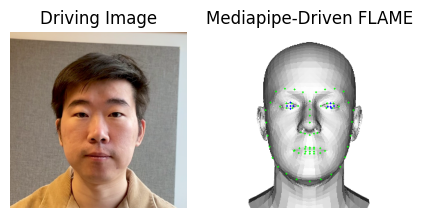

In [ ]:
## export .gif

from matplotlib.animation import FuncAnimation, PillowWriter

# Define base path to the directory containing the .npy files
# base_path = '/mnt/data3_hdd/peizhi/Datasets/IMAvatar_flame_new/subject1/MVI_1812'
# output_gif_path = os.path.join(DIR, "assets/flame_animation_1.gif")

# base_path = '/mnt/data3_hdd/peizhi/Datasets/IMAvatar_flame_new/subject2/MVI_1801'
# output_gif_path = os.path.join(DIR, "assets/flame_animation_2.gif")

base_path = '/mnt/data3_hdd/peizhi/Datasets/Personal_Videos_flame_new/peizhi-demo/IMG_3198'
output_gif_path = os.path.join(DIR, "assets/flame_animation_3.gif")


# Load list of .npy files
npy_files = sorted([file for file in os.listdir(base_path) if file.endswith('.npy')])

# Get list of .npy files that actually exist
existing_files = [file for file in npy_files if os.path.exists(os.path.join(base_path, file))]
existing_files.sort(key=lambda x : int(x.split('.')[0]))
existing_files = existing_files[::10]

# Initialize blendshape and other arrays
shape = np.zeros([1, 100], dtype=np.float32)
exp = np.zeros([1, 50], dtype=np.float32)
pose = np.zeros([1, 6], dtype=np.float32)
eye_pose = np.zeros([1, 6], dtype=np.float32)



# Create a figure for plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(5, 2.5))

# Function to load, process, and render each file
def load_and_render(file_name):
    # Construct the path to the .npy file
    path = os.path.join(base_path, file_name)
    
    # Load the .npy file
    loaded = np.load(path, allow_pickle=True)
    blendshape_scores = loaded['blendshape_scores'][None]  # Ensure it has shape [1, 52]
    
    # Calculate expression, pose, and eye_pose using the mappings
    exp, pose, eye_pose = mp2flame.convert(blendshape_scores=blendshape_scores)

    # Clear the axes
    ax1.clear()
    ax2.clear()
    
    # Plot the driving image on the left
    ax1.imshow(loaded['img'])
    ax1.axis('off')
    ax1.set_title("Driving Image")
    
    # Render the FLAME shape and plot on the right
    rendered_shape = render_flame_shape(shape, exp, pose, eye_pose)
    ax2.imshow(rendered_shape)
    ax2.axis('off')
    ax2.set_title("Mediapipe-Driven FLAME")

    print(file_name)


# Create animation using only existing files
anim = FuncAnimation(fig, load_and_render, frames=existing_files, interval=1, repeat=False)

# Save the animation as a GIF
anim.save(output_gif_path, writer=PillowWriter(fps=10), dpi=80)

print("GIF saved successfully at:", output_gif_path)



In [128]:
len(existing_files)

183